# Modeling

In [1]:
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, PrecisionRecallDisplay, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("../src")
import utils

rng = np.random.default_rng(10)

## 1. Preprocessing

TODO:
1. Join income and credit limit features from users data
1. Calculate "home city", "home state", "home country", user age, and retired features
1. Calculate card vintage and time to expiration features from card data
1. **What to do with MCCs?** There are 109 of them: too many to just make dummies? Perhaps they could be grouped according to fraud rates, though this would need to be done using only training data.
1. 70/30 train/test split. Because there are user-level measures, I think there is a need to avoid contamination. Also, this will be definitely necessary for alternative modeling methods that explicitly consider the user level.

Transactions

In [2]:
tx_data = pd.read_csv(
    utils.prepend_dir('tx_sample.csv'),
    index_col=0,
    parse_dates=['timestamp']
)
# tx_data.drop(['year', 'month', 'day', 'time', 'merchant_name', 'use_chip'], axis=1, inplace=True)
print(tx_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5214807 entries, 28882 to 24270533
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user            int64         
 1   card            int64         
 2   amount          float64       
 3   merchant_city   object        
 4   merchant_state  object        
 5   zip             float64       
 6   mcc             int64         
 7   errors          object        
 8   is_fraud        bool          
 9   timestamp       datetime64[ns]
 10  tx_type         object        
dtypes: bool(1), datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 442.6+ MB
None


Cards

In [3]:
card_data = pd.read_csv(
    utils.prepend_dir('cards_sample.csv'), 
    index_col=0, 
    parse_dates=['expires', 'acct_open_date']
)
print(card_data.info())
card_cols = ['user', 'card_index', 'card_brand', 'card_type', 'expires', 'has_chip', 'cards_issued', 'credit_limit', 'acct_open_date']

<class 'pandas.core.frame.DataFrame'>
Index: 1241 entries, 10 to 6109
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user                   1241 non-null   int64         
 1   card_index             1241 non-null   int64         
 2   card_brand             1241 non-null   object        
 3   card_type              1241 non-null   object        
 4   card_number            1241 non-null   int64         
 5   expires                1241 non-null   datetime64[ns]
 6   cvv                    1241 non-null   int64         
 7   has_chip               1241 non-null   bool          
 8   cards_issued           1241 non-null   int64         
 9   credit_limit           1241 non-null   float64       
 10  acct_open_date         1241 non-null   datetime64[ns]
 11  year_pin_last_changed  1241 non-null   int64         
 12  num_transactions       1241 non-null   int64         
 13  total_t

Users

In [4]:
user_data = pd.read_csv(
    utils.prepend_dir('users_sample.csv'),
    index_col=0
)
user_data['birthdate'] = pd.to_datetime({
    'year': user_data.birth_year, 
    'month': user_data.birth_month, 
    'day':1
})
print(user_data.info())
user_cols = ['birthdate', 'retirement_age', 'gender' ,'city', 'state', 'zipcode', 'latitude', 'longitude', 'per_capita_income_zipcode', 'yearly_income_person', 'total_debt', 'fico_score', 'num_credit_cards']

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 2 to 1987
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   person                     400 non-null    object        
 1   current_age                400 non-null    int64         
 2   retirement_age             400 non-null    int64         
 3   birth_year                 400 non-null    int64         
 4   birth_month                400 non-null    int64         
 5   gender                     400 non-null    object        
 6   address                    400 non-null    object        
 7   apartment                  102 non-null    float64       
 8   city                       400 non-null    object        
 9   state                      400 non-null    object        
 10  zipcode                    400 non-null    int64         
 11  latitude                   400 non-null    float64       
 12  longitude   

Merging data

In [5]:
merged_df = (tx_data
    .merge(
        card_data[card_cols],
        left_on=['user', 'card'],
        right_on=['user', 'card_index'])
    .merge(user_data[user_cols],
        left_on='user',
        right_index=True)
    .drop(columns=['card_index', 'card', 'user'])
)

print(merged_df.info())

# there's enought data that memory is a constraint
del tx_data
del user_data
del card_data

<class 'pandas.core.frame.DataFrame'>
Index: 5214807 entries, 0 to 5214806
Data columns (total 29 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   amount                     float64       
 1   merchant_city              object        
 2   merchant_state             object        
 3   zip                        float64       
 4   mcc                        int64         
 5   errors                     object        
 6   is_fraud                   bool          
 7   timestamp                  datetime64[ns]
 8   tx_type                    object        
 9   card_brand                 object        
 10  card_type                  object        
 11  expires                    datetime64[ns]
 12  has_chip                   bool          
 13  cards_issued               int64         
 14  credit_limit               float64       
 15  acct_open_date             datetime64[ns]
 16  birthdate                  datetime64[ns]

Constructing features

In [6]:
# location-based features
merged_df['home_city'] = (merged_df.city == merged_df.merchant_city) & (merged_df.state == merged_df.merchant_state)
merged_df['home_state'] = merged_df.state == merged_df.merchant_state
merged_df['home_zip'] = merged_df.zip == merged_df.zipcode
merged_df['overseas'] = (merged_df.tx_type != 'online') & merged_df.zip.isna()
merged_df = merged_df[~(merged_df.merchant_state.isna() & (merged_df.tx_type != 'online'))]

In [7]:
# time-based features
merged_df['user_age'] = (merged_df.timestamp - merged_df.birthdate).dt.days/365
merged_df['retired'] = merged_df.user_age >= merged_df.retirement_age
merged_df['until_expired'] = (merged_df.expires - merged_df.timestamp).dt.days
merged_df['since_opened'] = (merged_df.timestamp - merged_df.acct_open_date).dt.days

In [8]:
# dropping unneeded columns
redundant_cols = ['merchant_city', 'merchant_state', 'zip', 'city', 'state', 'zipcode', 'birthdate', 'retirement_age', 'expires', 'acct_open_date', 'timestamp']
merged_df.drop(columns=redundant_cols, inplace=True)

Converting categories to dummies

In [9]:
dummy_df = merged_df.copy()

errors = set()
for entry in merged_df.errors.dropna().unique().tolist():
    for error in entry.split(','):
        errors.add(error)
for error in list(errors):
    dummy_df[error] = dummy_df.errors.str.contains(error).fillna(False)
print(dummy_df.groupby('errors').agg({error:'sum' for error in errors}))
dummy_df.drop(columns='errors', inplace=True)

                                       Bad Expiration  Bad Card Number   
errors                                                                   
Bad CVV                                             0                0  \
Bad CVV,Insufficient Balance                        0                0   
Bad CVV,Technical Glitch                            0                0   
Bad Card Number                                     0             2883   
Bad Card Number,Bad CVV                             0               12   
Bad Card Number,Bad Expiration                      6                6   
Bad Card Number,Insufficient Balance                0               24   
Bad Card Number,Technical Glitch                    0                8   
Bad Expiration                                   2404                0   
Bad Expiration,Bad CVV                             14                0   
Bad Expiration,Insufficient Balance                19                0   
Bad Expiration,Technical Glitch       

In [10]:
dummy_df = pd.get_dummies(dummy_df, drop_first=True)
dummy_df.sample().T

,2818704
amount,6.43
mcc,5411
is_fraud,False
has_chip,True
cards_issued,2
credit_limit,13390.0
latitude,35.32
longitude,-82.46
per_capita_income_zipcode,13634.0
yearly_income_person,23993.0


TODO: deal with MCC codes

Training and test data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(dummy_df.drop(columns=['mcc', 'is_fraud']), dummy_df.is_fraud, random_state=10, stratify=dummy_df.is_fraud)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3909902, 34), (1303301, 34), (3909902,), (1303301,))

## Model assessment

In [18]:
def assess_model(model, name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # print metrics
    print('Training:')
    print(classification_report(y_train, y_pred_train))
    print('Validation:')
    print(classification_report(y_test, y_pred_test))

    # precision-recall plot
    _ = PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
    plt.axhline(0.01, color='red');
    plt.axis([0.5, 1., 0., 0.2]);
    plt.legend(loc='upper right');
    plt.title(f"Precision-Recall Curve for {name}");
    
    # save precision-recall table
    test_fraud_prob = model.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, test_fraud_prob)
    return pd.DataFrame({
        'precision':precision[:-1],
        'recall': recall[:-1]},
        index=thresholds
    )

## Logistic regression

In [12]:
# baseline model with default values

logit_pipe_default = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

assess_model(
    logit_pipe_default,
    'Logistic Regression with Defaults',
    X_train,
    X_test,
    y_train,
    y_test
)

# logit_pipe_default.fit(X_train, y_train)
# y_pred_train = logit_pipe_default.predict(X_train)
# y_pred_test = logit_pipe_default.predict(X_test)
# print('Training:')
# print(classification_report(y_train, y_pred_train))
# print('Validation:')
# print(classification_report(y_test, y_pred_test))

/home/mark/.local/share/virtualenvs/CreditCardFraud-EA29h7JT/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   3905365
        True       0.31      0.00      0.00      4537

    accuracy                           1.00   3909902
   macro avg       0.65      0.50      0.50   3909902
weighted avg       1.00      1.00      1.00   3909902

Validation:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   1301789
        True       0.55      0.00      0.01      1512

    accuracy                           1.00   1303301
   macro avg       0.77      0.50      0.50   1303301
weighted avg       1.00      1.00      1.00   1303301



In [13]:
# train_fraud_prob = logit_pipe_default.predict_proba(X_train)[:,1]
# test_fraud_prob = logit_pipe_default.predict_proba(X_test)[:,1]

In [14]:
# precision, recall, thresholds = precision_recall_curve(y_test, test_fraud_prob)
# logit_default_prc = pd.DataFrame({
#     'precision':precision[:-1],
#     'recall': recall[:-1]},
#     index=thresholds
# )
# logit_default_prc[logit_default_prc.recall>.5].tail()

,precision,recall
0.008286,0.022842,0.500661
0.008286,0.022843,0.500661
0.008286,0.022844,0.500661
0.008286,0.022845,0.500661
0.008286,0.022845,0.500661


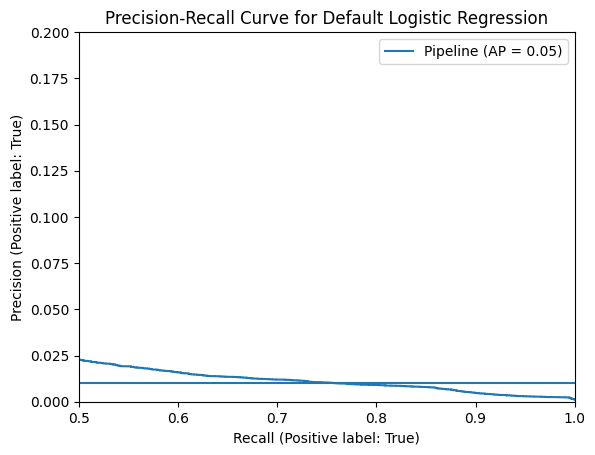

In [15]:
# prc_display = PrecisionRecallDisplay.from_estimator(logit_pipe_default, X_test, y_test)
# plt.axhline(0.01, color='red');
# plt.axis([0.5, 1., 0., 0.2]);
# plt.legend(loc='upper right');
# plt.title("Precision-Recall Curve for Default Logistic Regression");

With such an imbalanced data set, it is not surprising that the model gives very few transactions a majority probability of being fradulent. We can consider whether the model is at all better than pure than guessing by looking at the precision-recall curve, which shows it is better, but not by much. To catch about half of fraudulent transaction, a threshold of <1% is needed. At that level, over 40 legitimate transactions would be flagged as fraudulent.

The SAG solver is said to be better for larger samples.

In [12]:
logit_pipe_sag = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='sag')
)

logit_pipe_sag.fit(X_train, y_train)
y_pred_train = logit_pipe_sag.predict(X_train)
y_pred_test = logit_pipe_sag.predict(X_test)
print('Training:')
print(classification_report(y_train, y_pred_train))
print('Validation:')
print(classification_report(y_test, y_pred_test))
prc_display = PrecisionRecallDisplay.from_estimator(logit_pipe_sag, X_test, y_test)
plt.axhline(0.01);
plt.axis([0.5, 1., 0., 0.2]);
plt.legend(loc='upper right');
plt.title("Precision-Recall Curve for Logistic Regression with SAG solver");

/home/mark/.local/share/virtualenvs/CreditCardFraud-EA29h7JT/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   3905365
        True       0.32      0.00      0.01      4537

    accuracy                           1.00   3909902
   macro avg       0.66      0.50      0.50   3909902
weighted avg       1.00      1.00      1.00   3909902

Validation:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   1301789
        True       0.55      0.00      0.01      1512

    accuracy                           1.00   1303301
   macro avg       0.77      0.50      0.50   1303301
weighted avg       1.00      1.00      1.00   1303301



NameError: name 'logit_pipe_default' is not defined

## Dealing with balance

Sampling from negative training cases to have equal number of positives and negatives. As seen below, this results in a training set of just over 9,000 transactions. Interestingly, the results are mostly similar (if anything slightly worse), but with different thresholds. That is to say, whereas a threshold of ~0.02 had precision ~2% and recall of ~50%, with the balanced data, a threshold of 0.88 had similar performance.

Some thoughts:
1. More data might not hurt: could redo the original sampling such that there is an explicit "testing" subsample pulled directly from the original data, and then ALL positive transactions are pulled and matched to create balanced sample. This would in theory be something like 15,000 each fraudulent and legitimate transactions.
1. The smaller dataset (even 30,000, as opposed to 5 million) fits much more quickly: it is more viable to do some optimization and cross-validation to tune.

In [17]:
(non_fraud_indices,) = np.nonzero(~y_train)
(fraud_indices,) = np.nonzero(y_train)
balanced_indices = np.concatenate((fraud_indices, rng.choice(non_fraud_indices, size=len(fraud_indices))))
balanced_X_train = X_train.iloc[balanced_indices]
balanced_y_train = y_train.iloc[balanced_indices]
balanced_X_train.shape, balanced_y_train.shape

((9074, 34), (9074,))

Training:
              precision    recall  f1-score   support

       False       0.86      0.86      0.86      4537
        True       0.86      0.86      0.86      4537

    accuracy                           0.86      9074
   macro avg       0.86      0.86      0.86      9074
weighted avg       0.86      0.86      0.86      9074

Validation:
              precision    recall  f1-score   support

       False       1.00      0.86      0.92   1301789
        True       0.01      0.87      0.01      1512

    accuracy                           0.86   1303301
   macro avg       0.50      0.87      0.47   1303301
weighted avg       1.00      0.86      0.92   1303301

          precision    recall
0.875698   0.019392  0.500661
0.875698   0.019393  0.500661
0.875699   0.019393  0.500661
0.875700   0.019394  0.500661
0.875701   0.019394  0.500661


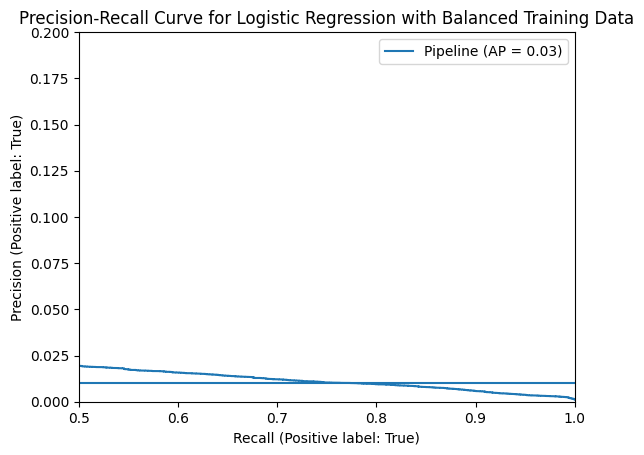

In [22]:
logit_pipe_balanced = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

logit_balanced_prc = assess_model(
    logit_pipe_balanced, 
    "Logistic Regression with Balanced Training Data",
    balanced_X_train,
    X_test,
    balanced_y_train,
    y_test
)
print(logit_balanced_prc[logit_balanced_prc.recall>0.5].tail())